### Zernike Projection: comparison of zernikeS.projection() and $Z_{mat}^{-1}$

In [1]:
import sys
import numpy as np
import math
import ceo
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

In [2]:
# Telescope parameters
D = 26.
nPx = 469
radial_order = 4
gmt = ceo.GMT_MX(D,nPx,M1_radial_order=radial_order,M2_radial_order=radial_order)

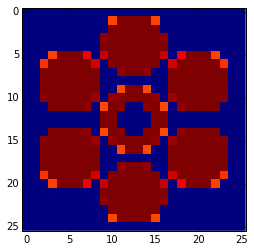

In [3]:
# on-axis WFS parameters
nLenslet = 26  # number of sub-apertures across the pupil
n = 18         # number of pixels per subaperture
detectorRes = 2*n*nLenslet/2
BINNING = 2

# Initialize on-axis GS and WFS
ongs = ceo.Source("R",zenith=0.,azimuth=0., rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n,BIN_IMAGE=BINNING,N_GS=1)

# Calibrate WFS slope null vector
ongs.reset()
gmt.reset()   # Telescope perfectly phased
gmt.propagate(ongs)
wfs.calibrate(ongs,0.8)
plt.imshow(wfs.flux.host(shape=(nLenslet,nLenslet)),interpolation='none')

In [4]:
print wfs.frame.shape
print "pupil sampling:      %d pixel"%nPx
print "Pixel size: %.3farcsec"%(wfs.pixel_scale_arcsec)
sh_fov = wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/BINNING
print "Field of view: %.3farcsec"%(sh_fov)

(468, 468)
pupil sampling:      469 pixel
Pixel size: 0.132arcsec
Field of view: 2.376arcsec


(1, 219961, 1)


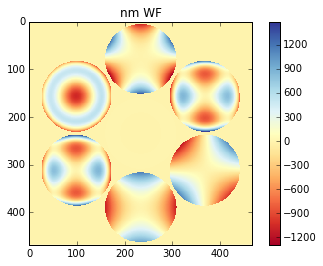

In [5]:
#Get residual WF solely due to telescope aberrations when perfectly aligned
ongs.reset()
gmt.reset()
gmt.propagate(ongs)
Wref = np.rollaxis( ongs.wavefront.phase.host(units='nm', shape=(1,ongs.N_SRC,ongs.n*ongs.m)),1,3)

#Put some Zernike modes on M1 segments and get the WF
zmode = np.array((5,4,11,8,10,11))
zstroke = 250e-9 #m rms SURF
ongs.reset()
gmt.reset()
for ii in range(zmode.size):
    gmt.M1.zernike.a[ii,zmode[ii]] = zstroke
    gmt.M1.zernike.update()
gmt.propagate(ongs)
W = np.rollaxis( ongs.wavefront.phase.host(units='nm', shape=(1,ongs.N_SRC,ongs.n*ongs.m)),1,3)
print W.shape

plt.imshow(ongs.phase.host(units='nm'),interpolation='None',cmap='RdYlBu')
plt.colorbar()
plt.title("nm WF")

#### Define $\rho$ and $\theta$ coordinates on each mirror segment mask

<matplotlib.colorbar.Colorbar instance at 0x2b55c5241cb0>

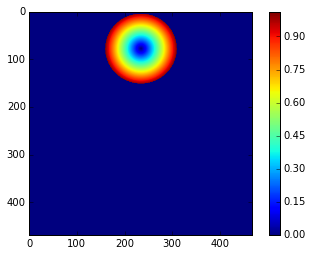

In [6]:
Zobj = ceo.ZernikeS(radial_order)
P = np.rollaxis( np.array( ongs.rays.piston_mask ),0,3)

# Find center coordinates (in pixels) of each segment mask
u = np.arange(ongs.n)
v = np.arange(ongs.m)
x,y = np.meshgrid(u,v)
x = x.reshape(1,-1,1)
y = y.reshape(1,-1,1)
xc = np.sum(x*P,axis=1)/P.sum(axis=1)
yc = np.sum(y*P,axis=1)/P.sum(axis=1)

# Preliminary estimation of radius (in pixels) of each segment mask (assuming that there is no central obscuration)
Rs = np.sqrt(P.sum(axis=1)/np.pi)

# Polar coordinates
rho   = np.hypot(   x - xc[:,np.newaxis,:], y - yc[:,np.newaxis,:])   #temporal rho vector
theta = np.arctan2( y - yc[:,np.newaxis,:], x - xc[:,np.newaxis,:]) * P

#Estimate central obscuration area of each segment mask
ObsArea = np.sum(rho < 0.9*Rs[:,np.newaxis,:] * ~P.astype('bool'), axis=1)

#Improve estimation of radius of each segment mask
Rs = np.sqrt( (P.sum(axis=1)+ObsArea) / np.pi)

#Normalize rho vector (unitary radius)
rho = rho / Rs[:,np.newaxis,:] * P #final rho vector

caca = rho[3,:,:].reshape(ongs.n,ongs.m)
plt.imshow(caca)
plt.colorbar()

#### Project segment phasemaps onto Zernikes using zernikeS.projection() method

[[  5.677   7.776   7.798  31.767   7.515  10.155   8.144   8.582   6.956
    8.265   8.64   -9.222   7.566   8.563   6.651]]
22.7215


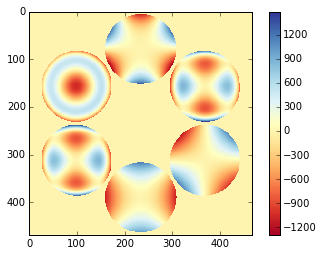

In [7]:
#Project a segment at a time:
segId = 3
alphaId = 0 #direction in the FoV (in case N_SRC > 0)

cutheta = ceo.cuDoubleArray(host_data=theta[segId-1,:,alphaId].reshape(ongs.m,ongs.n))
curho   = ceo.cuDoubleArray(host_data=  rho[segId-1,:,alphaId].reshape(ongs.m,ongs.n))
#myphase = ((W-Wref)[:,:,alphaId]*P[segId-1,:,alphaId]).reshape(ongs.n,ongs.m)  #just the WF over one segment
myphase = (W-Wref)[:,:,alphaId].reshape(ongs.n,ongs.m)
cuW = ceo.cuFloatArray(host_data=myphase)

plt.imshow(cuW.host(),interpolation='None',cmap='RdYlBu')
plt.colorbar()

Zobj.projection(cuW, curho, cutheta) 
arec1 = np.array(Zobj.a)
print np.array_str(arec1,precision=3,suppress_small=True)
print np.mean(myphase[P[segId-1,:,alphaId].reshape(nPx,nPx)==1])

<matplotlib.colorbar.Colorbar instance at 0x2b55c54d1b00>

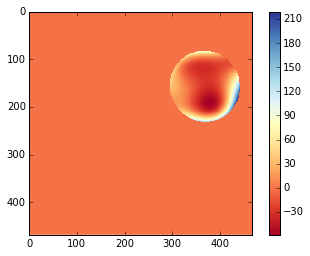

In [8]:
# Reconstructed phase map
Zobj.update()
ZS = Zobj.surface(curho,cutheta)
plt.imshow(ZS.host()*P[segId-1,:,alphaId].reshape(nPx,nPx),interpolation='None',cmap='RdYlBu')
plt.colorbar()

#### Project segment phasemaps onto Zernikes using the pseudo-inverse of Zmat

In [38]:
# Build an Zernike Influence-function Matrix
Zobj.reset()
Zmat = np.zeros((nPx*nPx,Zobj.n_mode))
for k in range(Zobj.n_mode):
    Zobj.a[0,k] = 1
    Zobj.update()
    S = Zobj.surface(curho,cutheta).host(shape=(nPx*nPx,1))*P[segId-1,:,alphaId].reshape(-1,1)
    Zmat[:,k] = S.flatten()
    Zobj.a[0,k] = 0

#plt.imshow(Zmat[:,14].reshape(nPx,nPx))
#plt.colorbar()

(15, 219961)


<matplotlib.colorbar.Colorbar instance at 0x2af9e813bc68>

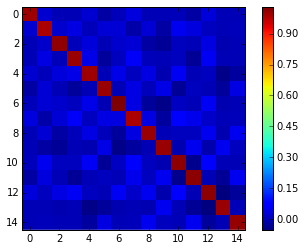

In [39]:
#Pseudo-inverse of Zmat
invZmat = np.linalg.pinv(Zmat)
print invZmat.shape

#Cross-product of Zernikes
GZ = np.dot(Zmat.T,Zmat)/P[segId-1,:,alphaId].sum()
plt.imshow(GZ,interpolation='None')
plt.colorbar()

In [67]:
arec = np.dot(invZmat, (W-Wref)[:,:,alphaId].reshape(-1))
print np.array_str(arec,precision=3,suppress_small=True)

[  13.05    22.815    6.742   11.996   -0.083   71.134   14.687   48.748
  -11.439   44.036   10.455 -430.742    0.119   14.772    0.755]


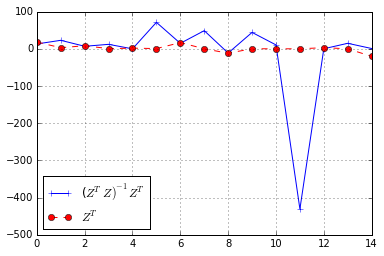

In [68]:
plt.plot(arec, '-+', label='($Z^T Z)^{-1} Z^T$')
plt.plot(arec1.T, 'r--o', label='$Z^T$')
plt.grid()
plt.legend(loc=3, fontsize='large')

In [91]:
arec1

array([[  2.08524129e+01,   2.56162410e+00,   2.01709198e+01,
          4.12947789e-01,  -4.46924236e+02,   5.69806544e-01,
         -1.49549997e+01,   5.08566871e-02,  -1.23565283e+01,
          1.45787022e-01,   9.17963854e-03,   9.56314260e-03,
         -3.37701461e-01,   3.62544763e-02,   1.07901938e+01]])